# Parking Violations Issued by New York City (FY16)

### Parking a car in the city is a miserable experience. This project will attempt to make it slightly less miserable through data science.

As part of New York's open data policy, the full dataset of parking violations issued each fiscal year is made publicly available. This project will explore the dataset from FY16. The full dataset contains over 10 million observations, but only data from passenger vehicles in NYPD Precinct 114 (which covers the northwest corner of Queens, including Astoria, Long Island City, and parts of Woodside and Jackson Heights) will be used.

# The Goal

![NYPD](IMG_20160701_083017.jpg)

The goal of the project is to discover if it is possible to predict whether a vehicle was issued a ticket for breaking alternate side parking rules (Violation Code 21) using information that could be known beforehand like vehicle make, vehicle color, and time of day.

# Project Summary

1. Isolate the relevant data.
2. Clean, clean, clean.
3. Decision Trees and Random Forests

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble, cross_validation, neighbors, tree, metrics

from IPython.display import Image
%matplotlib inline

# Set the default figure size for plotting
sns.mpl.rc("figure", figsize=(40,20))  # Larger default plots
sns.set_context("notebook", font_scale=1)  # Larger fonts

# Precinct 114

![Precinct 114](astoria-map.png)

## Exploratory Analysis of Precinct 114


The dataset contains mostly categorical data across 43 columns. There are four columns that contain no data and fifteen more that have missing data. A closer look shows that several of the fields are cryptically coded and might take some work to unpack, but there are enough columns that contain understandable information and are either complete or only missing a few values.

In [47]:
df = pd.read_csv('Parking_Violations_Issued_-_Fiscal_Year_2016.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10173437 entries, 0 to 10173436
Data columns (total 43 columns):
Summons Number                       int64
Plate ID                             object
Registration State                   object
Plate Type                           object
Issue Date                           object
Violation Code                       float64
Vehicle Body Type                    object
Vehicle Make                         object
Issuing Agency                       object
Street Code1                         float64
Street Code2                         float64
Street Code3                         float64
Vehicle Expiration Date              float64
Violation Location                   float64
Violation Precinct                   float64
Issuer Precinct                      float64
Issuer Code                          float64
Issuer Command                       object
Issuer Squad                         object
Violation Time                       obje

In [48]:
df = df[((df['Violation Precinct'] == 114) & (df['Plate Type'] == 'PAS'))]

In [49]:
df.shape

(225619, 43)

In [50]:
'''
time24 = []
for time in df['Violation Time']:
    hourminute = time[:4]
    ampm = time[-1:]
    if hourminute[0] not in ('0','1', '2'):
        hourminute = '0' + hourminute[1:]
    if hourminute[1] not in ('0','1','2','3','4','5','6','7','8','9'):
        hourminute = '00' + hourminute[2:]
    if hourminute[3] not in ('0','1','2','3','4','5','6','7','8','9'):
        hourminute = hourminute[:3] + '0'
    if ampm == 'P':
        if hourminute[:2] == '12':
            time24.append('00:' + hourminute[2:4] + ':00')
        else:
            hourminute = str(int(hourminute) + 1200)
            time24.append(hourminute[:2] + ':' + hourminute[2:4] + ':00')
    else:
        time24.append(hourminute[:2] + ':' + hourminute[2:4] + ':00')
        
df['Time'] = time24
'''
hour = []
minute = []
for time in df['Violation Time']:
    hourminute = time[:4]
    ampm = time[-1:]
    if hourminute[0] not in ('0','1', '2'):
        hourminute = '0' + hourminute[1:]
    if hourminute[1] not in ('0','1','2','3','4','5','6','7','8','9'):
        hourminute = '00' + hourminute[2:]
    if hourminute[3] not in ('0','1','2','3','4','5','6','7','8','9'):
        hourminute = hourminute[:3] + '0'
    if ampm == 'P':
        if hourminute[:2] == '12':
            hour.append(00)
            minute.append(int(hourminute[2:4]))
        else:
            hourminute = str(int(hourminute) + 1200)
            hour.append(int(hourminute[:2]))
            minute.append((hourminute[2:4]))
    else:
        hour.append(int(hourminute[:2]))
        minute.append(int(hourminute[2:4])) 
        
df['Hour'] = hour
df['Minute'] = minute

In [51]:
day = []
month = []
year = []

for date in df['Issue Date']:
    day.append(int(date[:2]))
    month.append(int(date[3:5]))
    year.append(int(date[6:]))
    
df['Day'] = day
df['Month'] = month
df['Year'] = year

In [70]:
def prep_df(df):
    #df['Datetime'] = pd.to_datetime(df['Issue Date'], infer_datetime_format=True)
    #df['Time'] = pd.to_datetime(df['Time'], format="%H:%M:%S")
    #df['Datetime'] = df['Issue Date'] + df['Time']
    
    df['Vehicle Year'] = df['Vehicle Year'].astype(int)
    
    return  df[[
             'Registration State', 
             'Vehicle Make',
             'Vehicle Body Type',
             'Violation Code', 
             'Vehicle Color',
             'Vehicle Year',
             'Street Code1',
             'Street Code2',
             'Street Code3',
             'Year',
             'Month',
             'Day',
             'Hour',
             'Minute']]

## Fixing Inconsistencies in Values and Dealing with Missing Values.

Looking at df_astoria_focused.info() shows that _Vehicle Make_, _Vehicle Color_, and _Vehicle Body Type_ are each missing a few values. The values in those fields are also wildly inconsistent. As an example, the _Vehicle Color_ column has the following variations of black: BK, BLACK, BLK, and possibly BL (which could also mean blue).

In [71]:
df['Vehicle Color'][df['Vehicle Color'].isin(['BLK', 'BLACK', 'BLCK', 'BLAK', 'BLAC', 'BL', 'B'])].value_counts()

BLACK    19090
BL       14848
BLK       1031
BLCK         7
BLAC         2
BLAK         1
B            1
Name: Vehicle Color, dtype: int64

In [153]:
df.columns

Index([u'Summons Number', u'Plate ID', u'Registration State', u'Plate Type',
       u'Issue Date', u'Violation Code', u'Vehicle Body Type', u'Vehicle Make',
       u'Issuing Agency', u'Street Code1', u'Street Code2', u'Street Code3',
       u'Vehicle Expiration Date', u'Violation Location',
       u'Violation Precinct', u'Issuer Precinct', u'Issuer Code',
       u'Issuer Command', u'Issuer Squad', u'Violation Time',
       u'Time First Observed', u'Violation County',
       u'Violation In Front Of Or Opposite', u'House Number', u'Street Name',
       u'Intersecting Street', u'Date First Observed', u'Law Section',
       u'Sub Division', u'Violation Legal Code', u'Days Parking In Effect    ',
       u'From Hours In Effect', u'To Hours In Effect', u'Vehicle Color',
       u'Unregistered Vehicle?', u'Vehicle Year', u'Meter Number',
       u'Feet From Curb', u'Violation Post Code', u'Violation Description',
       u'No Standing or Stopping Violation', u'Hydrant Violation',
       u'Double 

In [73]:
def clean_df(df):
    df.replace({'Vehicle Color': {'BL':'BLACK',
                                  'BK':'BLACK',
                                  'BLK':'BLACK',
                                  'BLCK':'BLACK',
                                  'BLACL':'BLACK',
                                  'BK/' : 'BLACK',
                                  'BKG' : 'BLACK',
                                  'BKR' : 'BLACK',
                                  'BLAC' : 'BLACK',
                                  'BKW' : 'BLACK',
                                  'BLB' : 'BLACK',
                                  'BL WH' : 'BLACK',
                                  'BLC' : 'BLACK',
                                  'BLN' : 'BLACK',
                                  'BCK' : 'BLACK',
                                  'BG' : 'BLACK',
                                  'BKYE' : 'BLACK',
                                  'B LAC' : 'BLACK',
                                  'BLAK' : 'BLACK',
                                  'B' : 'BLACK',
                                  'WH':'WHITE',
                                  'WHTIE':'WHITE',
                                  'WH':'WHITE',
                                  'WHTE': 'WHITE',
                                  'WH/' : 'WHITE',
                                  'WHT' : 'WHITE',
                                  'WHG' : 'WHITE',
                                  'WT' : 'WHITE',
                                  'W' : 'WHITE',
                                  'WHB' : 'WHITE',
                                  'WHR' : 'WHITE',
                                  'WHIET' : 'WHITE',
                                  'WHI' : 'WHITE',
                                  'WTE' : 'WHITE',
                                  'WHBK' : 'WHITE',
                                  'WHO' : 'WHITE',
                                  'WHY' : 'WHITE',
                                  'WH/OR' : 'WHITE',
                                  'WH/RD' : 'WHITE',
                                  'WH/BL' : 'WHITE',
                                  'WHIT' : 'WHITE',
                                  'KWH' : 'WHITE',
                                  'GY' : 'GREY',
                                  'GY/': 'GREY',
                                  'GRY' : 'GREY',
                                  'GAY' : 'GREY',
                                  'GR' : 'GREY',
                                  'GRAY': 'GREY',
                                  'GYW' : 'GREY',
                                  'GYB' : 'GREY',
                                  'DK GY' : 'GREY',
                                  'GRG' : 'GREY',
                                  'DARK' : 'GREY',
                                  'GRET' : 'GREY',
                                  'GRETY' : 'GREY',
                                  'LIGHT' : 'GREY',
                                  'GRR' : 'GREY',
                                  'DKGY' : 'GREY',
                                  'GRT' : 'GREY',
                                  'GERY' : 'GREY',
                                  'FRAY' : 'GREY',
                                  'DRKGY' : 'GREY',
                                  'DKGRY' : 'GREY',
                                  'GLT' : 'GREY',
                                  'GRW' : 'GREY',
                                  'GRT' : 'GREY',
                                  'GRAT' : 'GREY',
                                  'GYT' : 'GREY',
                                  'G' : 'GREY',
                                  'GU' : 'GREY',
                                  'GRE' : 'GREY',
                                  'GBY' : 'GREY',
                                  'RD' : 'RED',
                                  'RDB' : 'RED',
                                  'RD/' : 'RED',
                                  'RDO' : 'RED',
                                  'RDG' : 'RED',
                                  'RE' : 'RED',
                                  'RDY' : 'RED',
                                  'OR' : 'ORANGE',
                                  'RDT' : 'RED',
                                  'TN': 'TAN',
                                  'DKT' : 'TAN',
                                  'BEIGE' : 'TAN',
                                  'LTT' : 'TAN',
                                  'TNG' : 'TAN',
                                  'TN/' : 'TAN',
                                  'BEIGD' : 'TAN',
                                  'TANQ' : 'TAN',
                                  'BIEGE' : 'TAN',
                                  'BRIGE' : 'TAN',
                                  'BEIDG' : 'TAN',
                                  'BEGIE' : 'TAN',
                                  'YW' : 'YELLOW',
                                  'BR' : 'BROWN',
                                  'BRN' : 'BROWN',
                                  'BROW' : 'BROWN',
                                  'BWN' : 'BROWN',
                                  'BN' : 'BROWN',
                                  'BRW' : 'BROWN',
                                  'BRO' : 'BROWN',
                                  'BR/' : 'BROWN',
                                  'BRM' : 'BROWN',
                                  'BRE' : 'BROWN',
                                  'BW' : 'BROWN',
                                  'BRT' : 'BROWN',
                                  'BOWN' : 'BROWN',
                                  'GL' : 'GOLD', 
                                  'GLD' : 'GOLD',
                                  'GL/' : 'GOLD',
                                  'GD' : 'GOLD',
                                  'ORAN': 'ORANGE',
                                  'ORANG' : 'ORANGE',
                                  'OR' : 'ORANGE',
                                  'ORNAG' : 'ORANGE',
                                  'OR/' : 'ORANGE',
                                  'GRN' :'GREEN',
                                  'GN' : 'GREEN',
                                  'TEAL' : 'GREEN',
                                  'LIME' : 'GREEN',
                                  'GLG' : 'GREEN',
                                  'BLU' : 'BLUE',
                                  'SILVE' : 'SILVER',
                                  'SLIVE' : 'SILVER',
                                  'YELLO' : 'YELLOW',
                                  'YL' : 'YELLOW',
                                  'YLLW' :'YELLOW',
                                  'YELL' : 'YELLOW',
                                  'YEL' : 'YELLOW',
                                  'YLW' : 'YELLOW',
                                  'BK/GY' : 'BLACK',
                                  'LT/' : 'GREY',
                                  'DK' : 'GREY',
                                  'DK/' : 'GREY',
                                  'LTG': 'GREY',
                                  'GRU' : 'GREY',
                                  'SILV' : 'SILVER',
                                  'SLVR' : 'SILVER',
                                  'SL' : 'SILVER',
                                  'MR' : 'MAROON',
                                  'DKR' : 'MAROON',
                                  'MAROO' : 'MAROON',
                                  'BURG' : 'MAROON',
                                  'BURGU' : 'MAROON',
                                  'BUR' : 'MAROON',
                                  'BURGA' : 'MAROON',
                                  'BU' : 'MAROON',
                                  'DKM' : 'MAROON',
                                  'MATOO' : 'MAROON',
                                  'MD' : 'MAROON',
                                  'MR/' : 'MAROON',
                                  'GR/' : 'GREY',
                                  'DKB' : 'BLUE',
                                  'DKG' : 'GREEN',
                                  'SILVR':'SILVER',
                                  'SIL' : 'SILVER',
                                  'SLV' : 'SILVER',
                                  'SIKLV' : 'SILVER',
                                  'PURPL' : 'PURPLE',
                                  'PR' : 'PURPLE',
                                  'PR/' : 'PURPLE',
                                  'LAVEN' : 'PURPLE',
                                  'DKP' : 'PURPLE',
                                  'LN' : 'PURPLE',
                                  'YW/' : 'YELLOW',
                                  'YWB' : 'YELLOW',
                                  'Y/W' : 'YELLOW',
                                  'YW/BK' : 'YELLOW',
                                  'LTB' : 'BLUE',
                                  'BL/' : 'BLUE',
                                  'BLG' : 'BLUE',
                                  'BLW' : 'BLUE',
                                  'NAVY' : 'BLUE',
                                  'BLV' : 'BLUE',
                                  'PK' : 'PINK',
                                  'NO' : 'OTHER',
                                  'NOC' : 'OTHER',
                                  'TI I' : 'OTHER',
                                  'PLE' : 'OTHER',
                                  'MULTI' : 'OTHER',
                                  'IM' : 'OTHER',
                                  'BUICK' : 'OTHER',
                                  'SUBAR' : 'OTHER',
                                  'FORD' : 'OTHER',
                                  'GC' : 'OTHER',
                                  'GV' : 'OTHER',
                                  'LEXUS' : 'OTHER',
                                  'BJ' : 'OTHER',
                                  'CADIL' : 'OTHER',
                                  'BET' : 'OTHER',
                                  'VAN' : 'OTHER'
                                  }}, inplace=True)
    
    # Cleaning up the values in the 'Vehicle Body Type' field
    df.replace({'Vehicle Body Type': {'P-U':'PICKUP',
                                      'TK':'PICKUP',
                                      'SEDN' : 'SDN',
                                      'TR' : 'TRAC',
                                      'TRUC' : 'PICKUP',
                                      'T/CR' : 'TRAC',
                                      'TR/C' : 'TRAC',
                                      'UTII' : 'UTIL',
                                     }}, inplace=True)
    
    # Cleaning up the values in the 'Vehicle Makes' field
    df.replace({'Vehicle Make': {'5AAB':'SAAB',
                                 'AACUR' : 'ACURA',
                                 'BEN' : 'BENTL',
                                 'BENTI' : 'BENTL',
                                 'DUCET' : 'DUCAT',
                                 'FRIE' : 'FRIG',
                                 'FRGH' : 'FRIG',
                                 'FRIEG' : 'FRIG',
                                 'HNO' : 'HINO',
                                 'HYUAN' : 'HYUND',
                                 'INET' : 'INTER',
                                 'INETR' : 'INTER',
                                 'INTOR' : 'INTER',
                                 'INFIT' : 'INFIN',
                                 'INIER' : 'INTER',
                                 'INTI' : 'INTER',
                                 'KAWIS' : 'KAWAS',
                                 'KENO' : 'KENOW',
                                 'KENW' : 'KENOW',
                                 'KENWO': 'KENOW',
                                 'MAZEN' : 'MAZDA',
                                 'MAZSE' : 'MAZDA',
                                 'ME/BE' : 'ME',
                                 'MINE' : 'MINI',
                                 'MINIC' : 'MINI',
                                 'MISTI' : 'MITSU',
                                 'MNI' : 'MINI',
                                 'MOTOG' : 'MOTO',
                                 'NAVIS' : 'NAVI',
                                 'OLDMO' : 'OLDS',
                                 'OLDSM' : 'OLDS',
                                 'OLSSM' : 'OLDS',
                                 'PREV' : 'PREVO',
                                 'RIAGG' : 'RIGGI',
                                 'RO/R' : 'ROLLS',
                                 'R ROV' : 'ROVER',
                                 'SMRT' : 'SMART',
                                 'SNZKI' : 'SUZUK',
                                 'SUARU' : 'SUBAR',
                                 'SUBE' : 'SUBAR',
                                 'SUZNK' : 'SUZUK',
                                 'UT/M' : 'UTIL',
                                 'UTI' : 'UTIL',
                                 'UTILI' : 'UTIL',
                                 'VOLLK' : 'VOLKS',
                                 'WORH' : 'WORK',
                                 'WORKH' : 'WORK',
                                 'YAMAB' : 'YAMAT',
                                 'YAMAH' : 'YAMAT'          
                                      ,
                                     }}, inplace=True)
    
    df['Vehicle Year'] = df['Vehicle Year'].astype(int)
    df['Violation Code'] = df['Violation Code'].astype(int)
    df['Street Code1'] = df['Street Code1'].astype(int)
    df['Street Code2'] = df['Street Code2'].astype(int)
    df['Street Code3'] = df['Street Code3'].astype(int)
    df.replace({'Vehicle Year' : {0: df['Vehicle Year'].median()}}, inplace=True) 
    

### Missing Values
I will be imputing the missing _Vehicle Color_ fields with BLACK, which is the most frequent value. The missing values in _Vehicle Make_ will be filled with HONDA, and the _Vehicle Body Type_ field's missing values will become SUBN, which are the most frequent values in those fields.

In [74]:
def fillna_df(df):
    df['Vehicle Color'].fillna(df['Vehicle Color'].value_counts().index[0], inplace=True)
    df['Vehicle Make'].fillna(df['Vehicle Make'].value_counts().index[0], inplace=True)
    df['Vehicle Body Type'].fillna(df['Vehicle Body Type'].value_counts().index[0], inplace=True)
    

## Making Dummy Variables

Since six of the nine fields (including the outcome variable: _Violation Code_) are categorical, they are going to be broken out into dummy variables. I will also be separating the outcome variables into a separate dataframe in preparation for the analysis.

In [111]:
def dummies_df(df):
    state_dummies = pd.get_dummies(df['Registration State'], prefix='State', drop_first=True).astype(int)
    vehicle_make_dummies = pd.get_dummies(df['Vehicle Make'], prefix='Make', drop_first=True).astype(int)
    body_type_dummies = pd.get_dummies(df['Vehicle Body Type'], prefix='Body Type', drop_first=True).astype(int)
    vehicle_color_dummies = pd.get_dummies(df['Vehicle Color'], prefix='Color', drop_first=True).astype(int)
    street_code1_dummies = pd.get_dummies(df['Street Code1'], prefix='Street Code1', drop_first=True).astype(int)
    street_code2_dummies = pd.get_dummies(df['Street Code2'], prefix='Street Code2', drop_first=True).astype(int)
    street_code3_dummies = pd.get_dummies(df['Street Code3'], prefix='Street Code3', drop_first=True).astype(int)
    year_dummies = pd.get_dummies(df['Year'], prefix='Year', drop_first=True).astype(int)
    month_dummies = pd.get_dummies(df['Month'], prefix='Month', drop_first=True).astype(int)
    day_dummies = pd.get_dummies(df['Day'], prefix='Day', drop_first=True).astype(int)
    hour_dummies = pd.get_dummies(df['Hour'], prefix='Hour', drop_first=True).astype(int)
    minute_dummies = pd.get_dummies(df['Minute'], prefix='Minute', drop_first=True).astype(int)
    vehicle_year = df['Vehicle Year']
    #date = df['Datetime']

    df_dummies = pd.concat([state_dummies, 
                vehicle_make_dummies, 
                body_type_dummies, 
                vehicle_color_dummies,
                street_code1_dummies,
                street_code2_dummies,
                street_code3_dummies,
                year_dummies,
                month_dummies,
                day_dummies,
                hour_dummies,
                minute_dummies], axis=1)

    df_dummies['Vehicle Year'] = vehicle_year
    #df_dummies['Datetime'] = date
    #df_dummies['Hour'] = hour
    #df_dummies['Minute'] = minute
    
    
    return df_dummies

In [165]:
def dummies_no_time_df(df):
    state_dummies = pd.get_dummies(df['Registration State'], prefix='State', drop_first=True).astype(int)
    vehicle_make_dummies = pd.get_dummies(df['Vehicle Make'], prefix='Make', drop_first=True).astype(int)
    body_type_dummies = pd.get_dummies(df['Vehicle Body Type'], prefix='Body Type', drop_first=True).astype(int)
    vehicle_color_dummies = pd.get_dummies(df['Vehicle Color'], prefix='Color', drop_first=True).astype(int)
    street_code1_dummies = pd.get_dummies(df['Street Code1'], prefix='Street Code1', drop_first=True).astype(int)
    street_code2_dummies = pd.get_dummies(df['Street Code2'], prefix='Street Code2', drop_first=True).astype(int)
    street_code3_dummies = pd.get_dummies(df['Street Code3'], prefix='Street Code3', drop_first=True).astype(int)
    year_dummies = pd.get_dummies(df['Year'], prefix='Year', drop_first=True).astype(int)
    month_dummies = pd.get_dummies(df['Month'], prefix='Month', drop_first=True).astype(int)
    day_dummies = pd.get_dummies(df['Day'], prefix='Day', drop_first=True).astype(int)
    hour_dummies = pd.get_dummies(df['Hour'], prefix='Hour', drop_first=True).astype(int)
    minute_dummies = pd.get_dummies(df['Minute'], prefix='Minute', drop_first=True).astype(int)
    vehicle_year = df['Vehicle Year']
    #date = df['Datetime']

    df_dummies = pd.concat([state_dummies, 
                vehicle_make_dummies, 
                body_type_dummies, 
                vehicle_color_dummies,
                street_code1_dummies,
                street_code2_dummies,
                street_code3_dummies], axis=1)
                #year_dummies,
                #month_dummies,
                #day_dummies,
                #hour_dummies,
                #minute_dummies], 
                            

    df_dummies['Vehicle Year'] = vehicle_year
    #df_dummies['Datetime'] = date
    #df_dummies['Hour'] = hour
    #df_dummies['Minute'] = minute
    
    
    return df_dummies

## Running it All

In [154]:
astoriaX2 = prep_df(df)

clean_df(astoriaX2)

fillna_df(astoriaX2)

/home/trent/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/trent/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:260: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/trent/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

# Predictor Variables


In [82]:
print 'df.shape():', astoriaX.shape
astoriaX.head()

df.shape(): (225619, 14)


,Registration State,Vehicle Make,Vehicle Body Type,Violation Code,Vehicle Color,Vehicle Year,Street Code1,Street Code2,Street Code3,Year,Month,Day,Hour,Minute
53,NY,HONDA,SDN,40,GREEN,1996,0,40404,40404,2015,7,7,5,45
470,NY,MAZDA,SDN,21,BLACK,2009,64290,7240,7540,2015,2,7,8,7
471,NY,TOYOT,SDN,21,BLUE,2014,6940,7490,7640,2015,2,7,8,36
472,NY,HONDA,SDN,21,BLACK,2009,6440,10740,48990,2015,2,7,11,40
965,NY,SMART,TWOD,21,BLACK,2014,9090,28790,7540,2015,7,7,9,39


In [112]:
astoriaX = dummies_df(astoriaX)

X = astoriaX
y = df['Violation Code'].astype(int)

## Choosing Predictor Variables

The dataset contains mostly categorical data across its 43 columns. On first observation, there are four columns that contain no data and fifteen more that have missing data. 

In [8]:
df.head()

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,...,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation
53,1374160593,GRN9094,NY,PAS,07/07/2015,40.0,SDN,HONDA,P,0.0,...,GREEN,0,1996.0,-,0.0,NaN,NaN,NaN,NaN,NaN
470,1370558120,GTD1846,NY,PAS,07/02/2015,21.0,SDN,MAZDA,S,64290.0,...,BLK,0,2009.0,-,0.0,NaN,NaN,NaN,NaN,NaN
471,1370558132,GSH3421,NY,PAS,07/02/2015,21.0,SDN,TOYOT,S,6940.0,...,BLUE,0,2014.0,-,0.0,NaN,NaN,NaN,NaN,NaN
472,1370558144,GKJ8936,NY,PAS,07/02/2015,21.0,SDN,HONDA,S,6440.0,...,BLACK,0,2009.0,-,0.0,NaN,NaN,NaN,NaN,NaN
965,1373151894,GRH1305,NY,PAS,07/07/2015,21.0,TWOD,SMART,P,9090.0,...,BLK,0,2014.0,-,0.0,NaN,NaN,NaN,NaN,NaN


Looking a little more closely at the data shows that several of the fields are cryptically coded and might take some work to unpack, but there are enough columns that contain understandable information and are either complete or only missing a few values. 

![Figure 1](output_29_0.png)

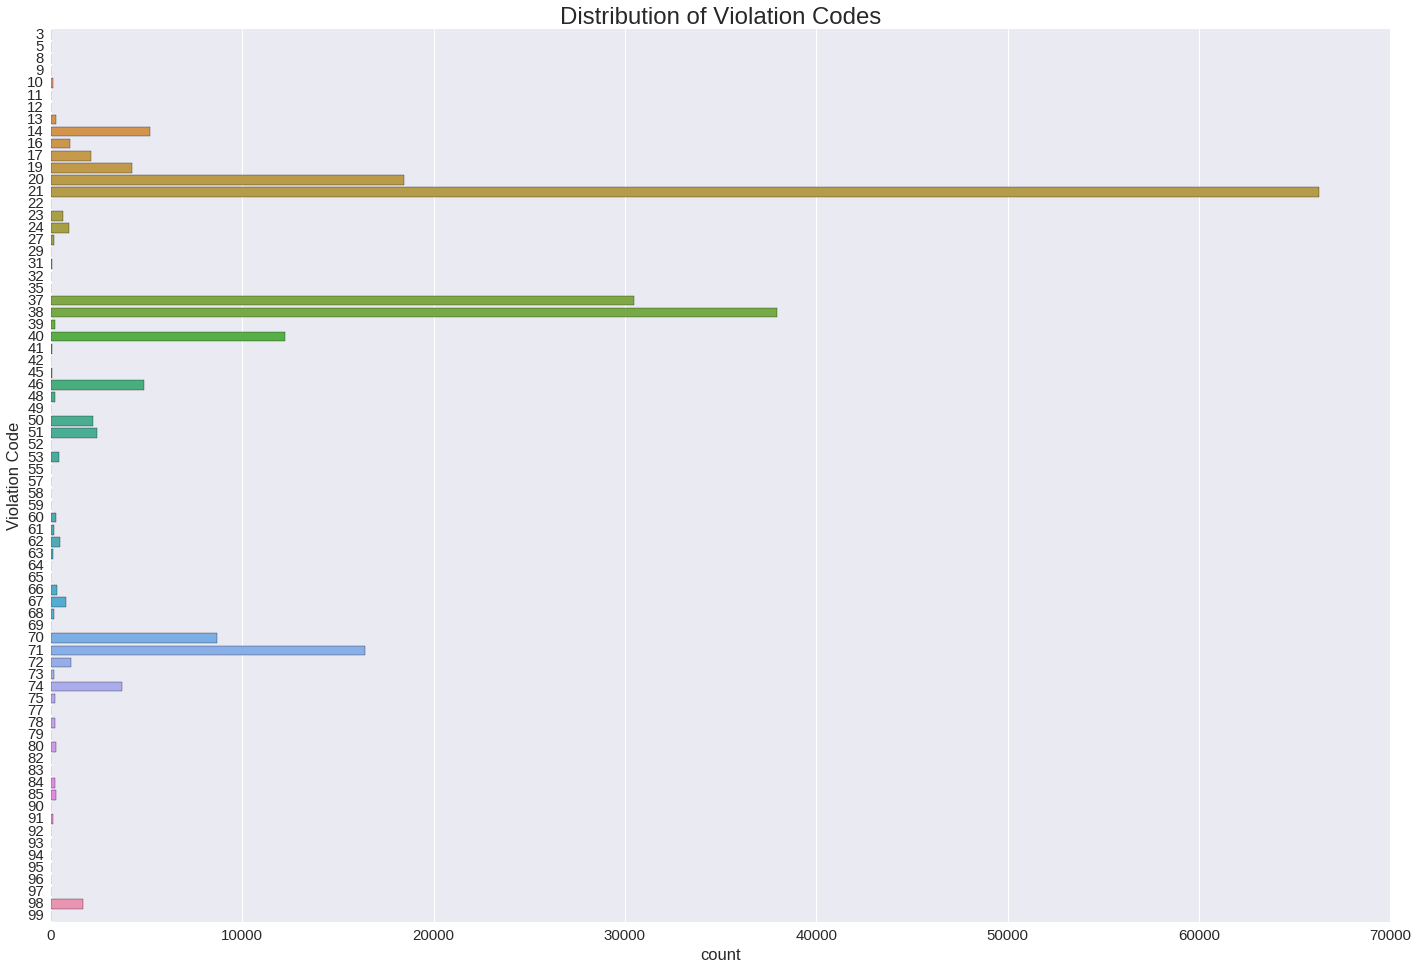

In [158]:
plt.figure(figsize=(24,16))
sns.set(font_scale=1.5)
sns.plt.title('Distribution of Violation Codes', fontsize=24)
sns.countplot(y="Violation Code", data=astoriaX2);

# Choosing a Single Outcome Variable


In [98]:
df2 = pd.read_csv('DOF_Parking_Violation_Codes.csv')
df2[(df2['CODE'] == '21')]

,CODE,DEFINITION,Manhattan 96th St. & below,All Other Areas
10,21,Street Cleaning: No parking where parking is n...,$65,$45


## How Do these Predictor Variables Relate to the Outcome Variable

In [100]:
y = df['Violation Code'].astype(int)
y_dummies = pd.get_dummies(y, prefix='Violation_Code')
y21 = y_dummies[['Violation_Code_21']]

chart1_X = astoriaX.drop(['Violation Code', 
                          'Street Code1', 
                          'Street Code2', 
                          'Street Code3'], axis=1)

chart1 = pd.concat([y21, chart1_X], axis=1)

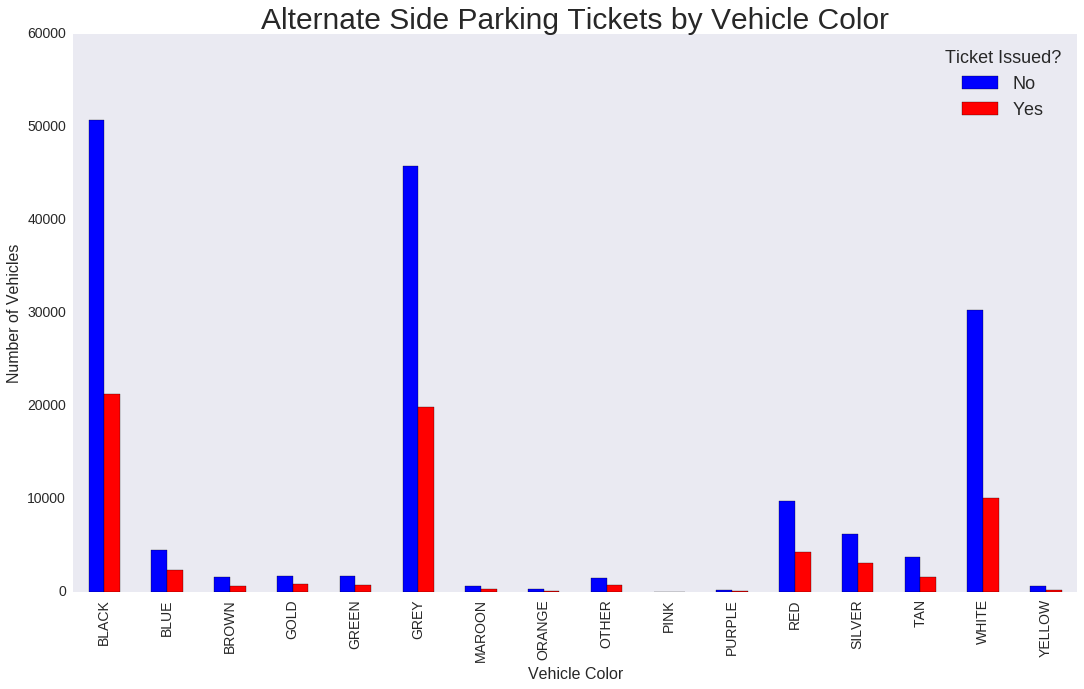

In [103]:
temp1 = pd.crosstab(chart1['Vehicle Color'], chart1['Violation_Code_21'])
figure = temp1.plot(kind='bar', stacked=False, grid=False, figsize=(18,10), fontsize=14, color = ['blue', 'red'])
figure.set_title('Alternate Side Parking Tickets by Vehicle Color', fontsize=30)
figure.set_xlabel('Vehicle Color', fontsize=16)
figure.axes
figure.set_ylabel('Number of Vehicles', fontsize=16)
figure.legend(['No', 'Yes'],title='Ticket Issued?', fontsize=18);

![Figure 2](output_33_0.png)

### Defining the Train/Test split

In [104]:
4# Borrowing this from Lesson 14
def format_model_results(sklearn_model, X_train, X_test, y_train, y_test):
    # Get the model's class name (E.g. LogisticRegression, KNearestNeighbor, etc.) and store it to a string
    model_class_name = sklearn_model.__class__.__name__  
    
    y_test_pred   = sklearn_model.predict(X_test)
    y_test_pred_proba   = sklearn_model.predict_proba(X_test)
    y_train_pred  = sklearn_model.predict(X_train)

    accuracy_score  = metrics.accuracy_score(y_test, y_test_pred)
    precision_score = metrics.precision_score(y_test, y_test_pred, average='binary')
    recall_score    = metrics.recall_score(y_test, y_test_pred, average='binary')
    f1_score        = metrics.f1_score(y_test, y_test_pred, average='binary')
    f1_score_train  = metrics.f1_score(y_train, y_train_pred, average='binary')
    
    return pd.DataFrame({
            "Accuracy": accuracy_score, 
            "Precision": precision_score, 
            "Recall": recall_score, 
            "F1 score": f1_score, 
            "F1 score (train)": f1_score_train
        }, index=[model_class_name])

In [182]:
# Same as above, but includes AUC score
def format_model_results2(sklearn_model, X_train, X_test, y_train, y_test):
    # Get the model's class name (E.g. LogisticRegression, KNearestNeighbor, etc.) and store it to a string
    model_class_name = sklearn_model.__class__.__name__  
    
    y_test_pred   = sklearn_model.predict(X_test)
    y_test_pred_proba   = sklearn_model.predict_proba(X_test)
    y_train_pred  = sklearn_model.predict(X_train)

    accuracy_score  = metrics.accuracy_score(y_test, y_test_pred)
    precision_score = metrics.precision_score(y_test, y_test_pred)
    recall_score    = metrics.recall_score(y_test, y_test_pred)
    f1_score        = metrics.f1_score(y_test, y_test_pred)
    f1_score_train  = metrics.f1_score(y_train, y_train_pred)
    auc_score       = metrics.roc_auc_score(y_test, y_test_pred_proba[:, 1], average='weighted')
    
    return pd.DataFrame({
            "Accuracy": accuracy_score, 
            "Precision": precision_score, 
            "Recall": recall_score, 
            "F1 score": f1_score, 
            "F1 score (train)": f1_score_train, 
            "AUC": auc_score
        }, index=[model_class_name])

In [181]:
metrics.roc_auc_score?

## Trying with a Random Forest

In [167]:
df_notime = dummies_no_time_df(astoriaX2)

In [168]:
X = df_notimemetrics.roc_auc_score
y = y_dummies['Violation_Code_21']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=42)

In [169]:
X.columns

Index([u'State_AB', u'State_AK', u'State_AL', u'State_AR', u'State_AZ',
       u'State_BC', u'State_CA', u'State_CO', u'State_CT', u'State_DC',
       ...
       u'Street Code3_67690', u'Street Code3_67990', u'Street Code3_68290',
       u'Street Code3_68690', u'Street Code3_70635', u'Street Code3_97340',
       u'Street Code3_97360', u'Street Code3_97400', u'Street Code3_97414',
       u'Vehicle Year'],
      dtype='object', length=1527)

In [173]:
rforest2 = ensemble.RandomForestClassifier(
    n_estimators = 3,
    oob_score=True, 
    max_depth=400
)


In [172]:
rforest2.fit(X_train, y_train)
format_model_results2(rforest2, X_train, X_test, y_train, y_test)

,AUC,Accuracy,F1 score,F1 score (train),Precision,Recall
RandomForestClassifier,0.765982,0.764146,0.576372,0.877216,0.600498,0.55411


# Overfitting

In [ ]:
rforest2 = ensemble.RandomForestClassifier(
    n_estimators = 3,
    oob_score=True, 
    max_depth=400
)

## Predicting just one outcome variable

In [106]:
y = df['Violation Code'].astype(int)

In [107]:
y_dummies = pd.get_dummies(y, prefix='Violation_Code')

In [113]:
X = astoriaX
y = y_dummies['Violation_Code_21']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=42)

In [118]:
rforest2.fit(X_train, y_train)
format_model_results2(rforest2, X_train, X_test, y_train, y_test)

/home/trent/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


,AUC,Accuracy,F1 score,F1 score (train),Precision,Recall
RandomForestClassifier,0.90393,0.861567,0.761493,0.957821,0.759791,0.763202


In [21]:
rforest2.fit(X_train, y_train)
format_model_results2(rforest2, X_train, X_test, y_train, y_test)

/home/trent/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


,Accuracy,F1 score,F1 score (train),Precision,Recall
RandomForestClassifier,0.868348,0.772522,0.959001,0.773015,0.772029


In [127]:
feature_importances = rforest2.feature_importances_
feature_names = X.columns

rforest2_features = pd.DataFrame({'Feature Name':feature_names, 'Feature Importance': feature_importances})


In [49]:
astoriaX.columns

Index([u'State_AB', u'State_AK', u'State_AL', u'State_AR', u'State_AZ',
       u'State_BC', u'State_CA', u'State_CO', u'State_CT', u'State_DC',
       ...
       u'Street Code3_67990.0', u'Street Code3_68290.0',
       u'Street Code3_68690.0', u'Street Code3_70635.0',
       u'Street Code3_97340.0', u'Street Code3_97360.0',
       u'Street Code3_97400.0', u'Street Code3_97414.0', u'Vehicle Year',
       u'Datetime'],
      dtype='object', length=1716)

In [25]:
print "Mean Score", cross_validation.cross_val_score(rforest2, X, y, scoring='accuracy').mean()

Mean Score 0.783959188996


In [ ]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

parameter_grid = [
  {'n_estimators': range(100, 502, 25), 'max_depth': range(100, 502, 25)}
 ]

clf = GridSearchCV(ensemble.RandomForestClassifier(), parameter_grid, cv=3)
clf.fit(X_train, y_train)

In [23]:
print "GRID SEARCH RESULTS"
print "\tBest Parameters", clf.best_params_
print "\tBest Score", clf.best_score_

pd.DataFrame(clf.grid_scores_).drop('cv_validation_scores', axis=1)

GRID SEARCH RESULTS
	Best Parameters {'n_estimators': 101, 'max_depth': 101}
	Best Score 0.793079445145


,parameters,mean_validation_score
0,"{u'n_estimators': 1, u'max_depth': 1}",0.729069
1,"{u'n_estimators': 26, u'max_depth': 1}",0.728242
2,"{u'n_estimators': 51, u'max_depth': 1}",0.728242
3,"{u'n_estimators': 76, u'max_depth': 1}",0.728242
4,"{u'n_estimators': 101, u'max_depth': 1}",0.728242
5,"{u'n_estimators': 1, u'max_depth': 26}",0.744232
6,"{u'n_estimators': 26, u'max_depth': 26}",0.746053
7,"{u'n_estimators': 51, u'max_depth': 26}",0.745609
8,"{u'n_estimators': 76, u'max_depth': 26}",0.744348
9,"{u'n_estimators': 101, u'max_depth': 26}",0.745589


In [76]:
feature_importances = rforest2.feature_importances_
feature_names = X.columns

rforest_features = pd.DataFrame({'Feature Name':feature_names, 'Feature Importance': feature_importances})

In [103]:
rforest2_features.sort('Feature Importance')

/home/trent/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,Feature Importance,Feature Name
639,0.000000,Street Code1_15940.0
808,0.000000,Street Code1_59590.0
807,0.000000,Street Code1_58990.0
806,0.000000,Street Code1_58690.0
805,0.000000,Street Code1_58620.0
804,0.000000,Street Code1_58590.0
803,0.000000,Street Code1_58390.0
809,0.000000,Street Code1_59790.0
802,0.000000,Street Code1_57890.0
1442,0.000000,Street Code3_12590.0


## Reducing the Number of Features based on Feature Importance

In [116]:
X.shape

(225619, 1723)

In [128]:
df_keep = rforest2_features['Feature Name'][(rforest2_features['Feature Importance'] < rforest2_features['Feature Importance'].quantile(.4))]

len(df_keep)

686

In [129]:
astoriaX.drop(rforest2_features['Feature Name'][(rforest2_features['Feature Importance'] < rforest2_features['Feature Importance'].quantile(.4))], axis=1, inplace=True)


In [130]:
astoriaX.shape

(283215, 1030)

In [131]:
astoriaX['Vehicle Year']

53          1996
470         2009
471         2014
472         2009
965         2014
966         2001
967         2009
968         2007
969         2007
1031        2014
1033        2013
1474        2007
1475        2012
1476        1999
1510        2012
1511        2015
1512        2015
2032        2009
2033        2007
2034        2015
2035        2012
2036        2007
2037        2003
2038        2006
2039        2003
2040        2002
3002        2015
3003        2006
3004        2008
3005        2013
            ... 
10170218    2010
10170219    2007
10170220    2007
10170221    2007
10170222    2011
10170223    2010
10170224    2013
10170225    2007
10170226    2005
10170227    2002
10170228    2007
10171053    2007
10171054    2007
10171055    2007
10171056    2007
10171057    2012
10172349    2008
10172350    2015
10172351    2007
10172352    2011
10172353    2013
10172354    2007
10172355    2007
10172356    2015
10172357    2008
10172358    2015
10172359    2001
10172360    20

In [115]:
rforest2_features['Feature Importance'].quantile(.4)

1.1353535915250669e-06

In [132]:
X = astoriaX.drop('Datetime', axis=1)
y = y_dummies['Violation_Code_21']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=42)

### These are the scores you get when you drop the wrong half of the dataframe

In [48]:
rforest2.fit(X_train, y_train)
format_model_results(rforest2, X_train, X_test, y_train, y_test)

,Accuracy,F1 score,F1 score (train),Precision,Recall
RandomForestClassifier,0.727829,0.00095,0.001373,0.37931,0.000476


In [135]:
rforest3 = ensemble.RandomForestClassifier(
    n_estimators = 10,
    oob_score=True, 
    max_features=200,
    max_depth=70
)

In [136]:
rforest3.fit(X_train, y_train)
format_model_results(rforest3, X_train, X_test, y_train, y_test)

,Accuracy,F1 score,F1 score (train),Precision,Recall
RandomForestClassifier,0.791808,0.545118,0.800034,0.672142,0.458474


In [165]:
rforest4 = ensemble.RandomForestClassifier(
    n_estimators = 10,
    oob_score=True, 
    max_features=400,
    max_depth=200
    
)

In [156]:
rforest4.fit(X_train, y_train)
format_model_results(rforest4, X_train, X_test, y_train, y_test)

,Accuracy,F1 score,F1 score (train),Precision,Recall
RandomForestClassifier,0.797881,0.604482,0.927771,0.646421,0.567653


In [162]:
X = astoriaX.drop('Datetime', axis=1)
yall = df['Violation Code'].astype(int)

X_train, X_test, yall_train, yall_test = cross_validation.train_test_split(X, yall, test_size=0.3, random_state=42)

In [159]:
rforest4.fit(X_train, yall_train)
format_model_results(rforest4, X_train, X_test, yall_train, yall_test)

/home/trent/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/trent/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/trent/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or mult

,Accuracy,F1 score,F1 score (train),Precision,Recall
RandomForestClassifier,0.453363,0.441361,0.888957,0.436208,0.453363


In [166]:
rforest4.fit(X_train, yall_train)
format_model_results(rforest4, X_train, X_test, yall_train, yall_test)

/home/trent/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/trent/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

,Accuracy,F1 score,F1 score (train),Precision,Recall
RandomForestClassifier,0.451927,0.439231,0.872542,0.434146,0.451927


With datetime as object

In [172]:
rforest4.fit(X_train, y_train)
format_model_results(rforest4, X_train, X_test, y_train, y_test)

,Accuracy,F1 score,F1 score (train),Precision,Recall
RandomForestClassifier,0.796222,0.595562,0.911499,0.647369,0.551432


### Adding columns for Time-based variables:
- Year
- Month
- Day
- Hour
- Minute

In [174]:
X = astoriaX.drop('Datetime', axis=1)
y = y_dummies['Violation_Code_21']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=42)

In [177]:
rforest2.fit(X_train, y_train)
format_model_results2(rforest2, X_train, X_test, y_train, y_test)

,AUC,Accuracy,F1 score,F1 score (train),Precision,Recall
RandomForestClassifier,0.915884,0.872544,0.781324,0.955987,0.776345,0.786367


In [184]:
rforest4.fit(X_train, yall_train)
format_model_results(rforest4, X_train, X_test, yall_train, yall_test)

/home/trent/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/trent/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

,Accuracy,F1 score,F1 score (train),Precision,Recall
RandomForestClassifier,0.551404,0.525573,0.976909,0.518935,0.551404


In [37]:
rforest5 = ensemble.RandomForestClassifier(
    n_estimators = 10,
    oob_score=True, 
    max_features=600,
    max_depth=600
    
)

In [190]:
rforest5.fit(X_train, y_train)
format_model_results(rforest5, X_train, X_test, y_train, y_test)

,Accuracy,F1 score,F1 score (train),Precision,Recall
RandomForestClassifier,0.915553,0.844955,0.989992,0.844207,0.845705


In [38]:
rforest6 = ensemble.RandomForestClassifier(
    n_estimators = 10,
    oob_score=True, 
    max_features=700,
    max_depth=700
    
)

rforest6.fit(X_train, y_train)
format_model_results(rforest6, X_train, X_test, y_train, y_test)

NameError: name 'X_train' is not defined

In [122]:
astoriaX.shape

(225619, 1723)

In [123]:
astoriaX.drop(rforest2_features['Feature Name'][(rforest2_features['Feature Importance'] < rforest2_features['Feature Importance'].quantile(.4))], axis=1, inplace=True)

X = astoriaX.drop('Datetime', axis=1)
y = y_dummies['Violation_Code_21']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=42)

NameError: name 'rforest2_features' is not defined

In [124]:
X.shape

(225619, 1723)

In [125]:
rforest6 = ensemble.RandomForestClassifier(
    n_estimators = 20,
    oob_score=True, 
    max_features=200,
    max_depth=30
    
)

rforest6.fit(X_train, y_train)
format_model_results(rforest6, X_train, X_test, y_train, y_test)

,Accuracy,F1 score,F1 score (train),Precision,Recall
RandomForestClassifier,0.878631,0.782494,0.824381,0.813264,0.753967


### Looking at the Feature Importances for rforest6

In [126]:
feature_importances = rforest6.feature_importances_
feature_names = X.columns

rforest6_features = pd.DataFrame({'Feature Name':feature_names, 'Feature Importance': feature_importances})

In [127]:
rforest6_features.sort('Feature Importance')

/home/trent/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,Feature Importance,Feature Name
593,0.000000,Street Code1_36490
717,0.000000,Street Code2_5940
1355,0.000000,Street Code3_19990
720,0.000000,Street Code2_6140
721,0.000000,Street Code2_6190
1354,0.000000,Street Code3_19940
1353,0.000000,Street Code3_19740
1352,0.000000,Street Code3_19690
1350,0.000000,Street Code3_19390
1347,0.000000,Street Code3_19090


In [128]:
len(rforest6_features[(rforest6_features['Feature Importance'] == 0)])

857

In [129]:
# Dropping columns with a feature importance of 0
astoriaX.drop(rforest6_features['Feature Name'][(rforest6_features['Feature Importance'] == 0)], axis=1, inplace=True)

X = astoriaX.drop('Datetime', axis=1)
y = y_dummies['Violation_Code_21']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=42)

In [130]:
X.shape

(225619, 859)

In [131]:
rforest6 = ensemble.RandomForestClassifier(
    n_estimators = 20,
    oob_score=True, 
    max_features=200,
    max_depth=30
    
)

rforest6.fit(X_train, y_train)
format_model_results(rforest6, X_train, X_test, y_train, y_test)

,Accuracy,F1 score,F1 score (train),Precision,Recall
RandomForestClassifier,0.881172,0.789257,0.83425,0.811214,0.768458


In [132]:
feature_importances = rforest6.feature_importances_
feature_names = X.columns

rforest6_features = pd.DataFrame({'Feature Name':feature_names, 'Feature Importance': feature_importances})
rforest6_features.sort('Feature Importance')

/home/trent/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Feature Importance,Feature Name
0,0.000000,State_AB
316,0.000000,Street Code1_19540
318,0.000000,Street Code1_20190
320,0.000000,Street Code1_22590
330,0.000000,Street Code1_38110
331,0.000000,Street Code1_38690
346,0.000000,Street Code1_58390
312,0.000000,Street Code1_18590
373,0.000000,Street Code2_6300
418,0.000000,Street Code2_8205


In [133]:
len(rforest6_features[(rforest6_features['Feature Importance'] == 0)])

82

In [184]:
# Dropping MORE columns with a feature importance of 0
#astoriaX.drop(rforest6_features['Feature Name'][(rforest6_features['Feature Importance'] == 0)], axis=1, inplace=True)

X = astoriaX.drop('Datetime', axis=1)
y = y_dummies['Violation_Code_21']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=42)

In [135]:
rforest6.fit(X_train, y_train)
format_model_results(rforest6, X_train, X_test, y_train, y_test)

,Accuracy,F1 score,F1 score (train),Precision,Recall
RandomForestClassifier,0.876193,0.787955,0.828293,0.781587,0.794428


In [136]:
format_model_results2(rforest6, X_train, X_test, y_train, y_test)

,AUC,Accuracy,F1 score,F1 score (train),Precision,Recall
RandomForestClassifier,0.946107,0.876193,0.787955,0.828293,0.781587,0.794428


In [185]:
rforest7 = ensemble.RandomForestClassifier(
    n_estimators = 20,
    oob_score=True, 
    max_features=300,
    max_depth=20
    
)

rforest7.fit(X_train, y_train)
format_model_results2(rforest7, X_train, X_test, y_train, y_test)

,AUC,Accuracy,F1 score,F1 score (train),Precision,Recall
RandomForestClassifier,0.927226,0.85384,0.759908,0.775683,0.724614,0.798816


### Looking at Feature Importances for rforest7

In [138]:
feature_importances = rforest7.feature_importances_
feature_names = X.columns

rforest7_features = pd.DataFrame({'Feature Name':feature_names, 'Feature Importance': feature_importances})

rforest7_features.sort('Feature Importance')

/home/trent/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Feature Importance,Feature Name
270,0.000000,Street Code1_15540
606,0.000000,Street Code3_47390
194,0.000000,Street Code1_7590
106,0.000000,Make_SUNBE
607,0.000000,Street Code3_48990
304,0.000000,Street Code1_52390
109,0.000000,Make_TRAIL
734,0.000000,Minute_12
111,0.000000,Make_UD
112,0.000000,Make_ULTR


In [139]:
len(rforest7_features[(rforest7_features['Feature Importance'] == 0)])

143

In [140]:
# Dropping EVEN MORE columns with a feature importance of 0
astoriaX.drop(rforest7_features['Feature Name'][(rforest7_features['Feature Importance'] == 0)], axis=1, inplace=True)

X = astoriaX.drop('Datetime', axis=1)
y = y_dummies['Violation_Code_21']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=42)

In [141]:
rforest7.fit(X_train, y_train)
format_model_results2(rforest7, X_train, X_test, y_train, y_test)

,AUC,Accuracy,F1 score,F1 score (train),Precision,Recall
RandomForestClassifier,0.927075,0.855273,0.763576,0.779,0.724479,0.807133


In [142]:
n_folds = 5

cv_score = cross_validation.cross_val_score(rforest7, X, y, cv=n_folds, scoring='roc_auc')

print "Avg AUC Score across %s folds: %s" % (n_folds, cv_score.mean())

rforest7.feature_importances_

Avg AUC Score across 5 folds: 0.924774573408


array([  1.97867398e-05,   2.01869086e-05,   5.45667694e-05,
         2.34214359e-05,   1.47271472e-04,   1.23726579e-05,
         1.74303019e-04,   9.69174124e-06,   4.65272406e-06,
         1.28511259e-05,   1.25141866e-04,   7.57465929e-05,
         8.91787122e-05,   1.05666028e-04,   2.80783198e-05,
         7.21813079e-05,   2.61274463e-05,   7.15303315e-06,
         4.95331812e-05,   6.40874332e-05,   4.52309713e-06,
         3.23322694e-04,   0.00000000e+00,   5.68834799e-06,
         2.28584137e-05,   1.14978804e-03,   9.24293547e-05,
         2.61664939e-05,   1.23714266e-05,   3.88400690e-05,
         3.24767922e-04,   7.04200329e-06,   5.53346726e-06,
         4.12836014e-05,   3.43942055e-05,   2.17700515e-05,
         4.63218135e-05,   0.00000000e+00,   6.57418955e-05,
         1.35017900e-05,   1.91139103e-05,   3.24798663e-04,
         2.59004766e-04,   3.33521724e-04,   7.38005118e-05,
         1.83840901e-04,   3.90051028e-04,   1.33403757e-04,
         5.60814434e-06,

In [143]:
feature_importances = rforest7.feature_importances_
feature_names = X.columns

rforest7_features = pd.DataFrame({'Feature Name':feature_names, 'Feature Importance': feature_importances})

In [144]:
len(rforest7_features[(rforest7_features['Feature Importance'] == 0)])

84

In [145]:
# Another round of dropping columns with a feature importance of 0
astoriaX.drop(rforest7_features['Feature Name'][(rforest7_features['Feature Importance'] == 0)], axis=1, inplace=True)

X = astoriaX.drop('Datetime', axis=1)
y = y_dummies['Violation_Code_21']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=42)

In [146]:
rforest7.fit(X_train, y_train)
format_model_results2(rforest7, X_train, X_test, y_train, y_test)

,AUC,Accuracy,F1 score,F1 score (train),Precision,Recall
RandomForestClassifier,0.927499,0.853633,0.760486,0.774974,0.722661,0.80249


### Making the time categorical

In [147]:
astoriaX.shape

(225619, 514)

### Trying the model on the full _Violation Code_ column

In [183]:
X = astoriaX
yall = df['Violation Code'].astype(int)

X_train, X_test, yall_train, yall_test = cross_validation.train_test_split(X, yall, test_size=0.3, random_state=42)

In [149]:
rforest7.fit(X_train, y_train)
format_model_results2(rforest7, X_train, X_test, y_train, y_test)

,AUC,Accuracy,F1 score,F1 score (train),Precision,Recall
RandomForestClassifier,0.927033,0.852865,0.759926,0.774269,0.720252,0.804225


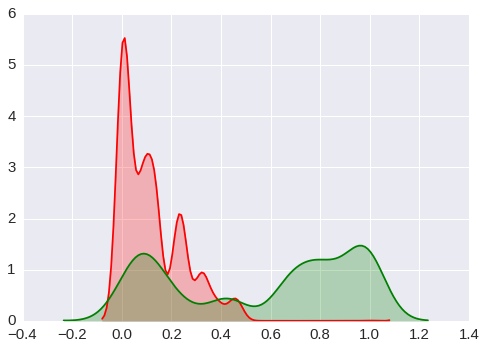

In [179]:
y_test_pred_proba   = rforest7.predict_proba(X_test)

fpr, tpr, _ = metrics.roc_curve(y_test, y_test_pred_proba[:, 1])

sns.kdeplot(fpr, c="red", shade=True)
sns.kdeplot(tpr, c="green", shade=True);


0.927033242626


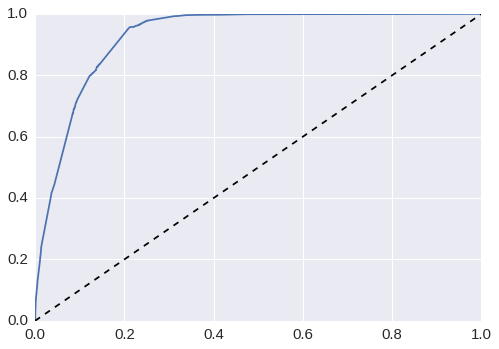

In [180]:
roc_auc = metrics.auc(fpr, tpr)

plt.xlim = [0, 1]
plt.ylim = [0, 1]
ax = plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')

print metrics.roc_auc_score(y_test, y_test_pred_proba[:, 1])

# Conclusion

1. For all of the possible predictor variables, only a small percentage matters.
2. Time variables are important.
3. Reducing the depth of the model helps with overfitting issues.

# Next Steps

1. Test the model using _cross-validation_ and _grid search_.
2. Perform a timeseries analysis of the data.
3. Test the model with the full _NYC Parking Violations_ dataset.

# Thank You!
![NYPD](IMG_20160701_083017.jpg)